In [1]:
import pandas as pd
import numpy as np 
import xgboost as xgb
import matplotlib.pyplot as plt
from xgboost import plot_importance 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# target_ToolGID = 'PK_DUVKrF'
target_ToolGID = 'XE_Sorter'

def readDataFromFile(file_path):
    df = pd.read_csv(file_path)
    return df

df_train=readDataFromFile('../../homework/training_data_20210302.csv')
df_train = df_train.loc[df_train['TOOLG_ID']==target_ToolGID]
# 觀察缺失值------------------------------------------
print(df_train.isnull().sum())
# 做数据切分------------------------------------------
print(df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1).describe())
# df_train_eh =pd.get_dummies(df_train.drop(['MOVE_QTY','MFG_DATE','AI'], axis=1),columns= [ 'TOOLG_ID'])
X_dropped = np.asarray(df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1))
Y_dropped = np.asarray(df_train['MOVE_QTY'])

X_train, X_val, y_train, y_val = train_test_split(X_dropped, Y_dropped, random_state=1) #Seed： 亂數種子，可以固定我們切割資料的結果random_state=777,
#調參------------------------------------------------------------
cv_params = {'n_estimators': [400, 500, 600, 700],'max_depth':[3,5,7],'min_child_weight':[1,3,5]}
other_params = {'learning_rate': 0.1, 'n_estimators': 500, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=4)

optimized_GBM.fit(X_train, y_train) 

test_score = optimized_GBM.score(X_val,y_val)

print('test 得分:{0}'.format(test_score))
# evalute_result = optimized_GBM.grid_scores_
# print('每輪迭代執行結果:{0}'.format(evalute_result))
 
print('引數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))
print('cv_results_',optimized_GBM.cv_results_)



MFG_DATE       0
TOOLG_ID       0
WIP_QTY        0
NO_HOLD_QTY    0
MOVE_QTY       0
M              1
U              1
PT             0
UP_TIME        1
EQP_UTIL       1
TC             0
CS             0
AI             0
C_AI           0
dtype: int64
           WIP_QTY  NO_HOLD_QTY          M           U          PT  \
count   401.000000   401.000000  400.00000  400.000000  401.000000   
mean   2298.670823  1270.147132   16.79250    0.815054  262.588917   
std     609.330950   595.039625    1.01835    0.101562   16.646263   
min    1058.000000   431.000000   15.00000    0.055358  225.525207   
25%    1884.000000   870.000000   16.00000    0.804221  249.536313   
50%    2225.000000  1158.000000   17.00000    0.823748  267.549756   
75%    2592.000000  1550.000000   17.00000    0.850040  275.244853   
max    6795.000000  6099.000000   18.00000    0.940454  298.657525   

          UP_TIME    EQP_UTIL          TC          CS        C_AI  
count  400.000000  400.000000  401.000000  401.000

XGBRegressor(base_score=None, booster=None, colsample_bylevel=None,
             colsample_bynode=None, colsample_bytree=0.8, gamma=0, gpu_id=None,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=None, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             random_state=None, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=None, seed=0, subsample=0.8, tree_method=None,
             validate_parameters=None, verbosity=None)


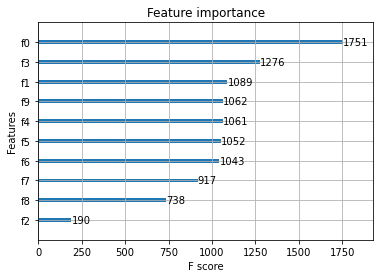

In [2]:
#===================================================
# 方法1
#===================================================
# # # 找出最重要的特徵 (值越大，特徵越重要)
 
# other_params = {'learning_rate': 0.1, 'n_estimators': 400, 'max_depth': 5, 'min_child_weight': 1, 'seed': 0,
# 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 0, 'reg_alpha': 0, 'reg_lambda': 1}
# model = xgb.XGBRegressor(**other_params)
# model.set_params(n_estimators=700) 
# model.set_params(min_child_weight=5) 
# model.set_params(max_depth=9) 
#引數的最佳取值：{'max_depth': 9, 'min_child_weight': 5, 'n_estimators': 700}
#===================================================
# 方法2
#===================================================
bst_model = optimized_GBM.estimator
print(bst_model)

bst_model.fit(X_train, y_train)
plot_importance(bst_model)#,max_num_features=10)
plt.show()

 

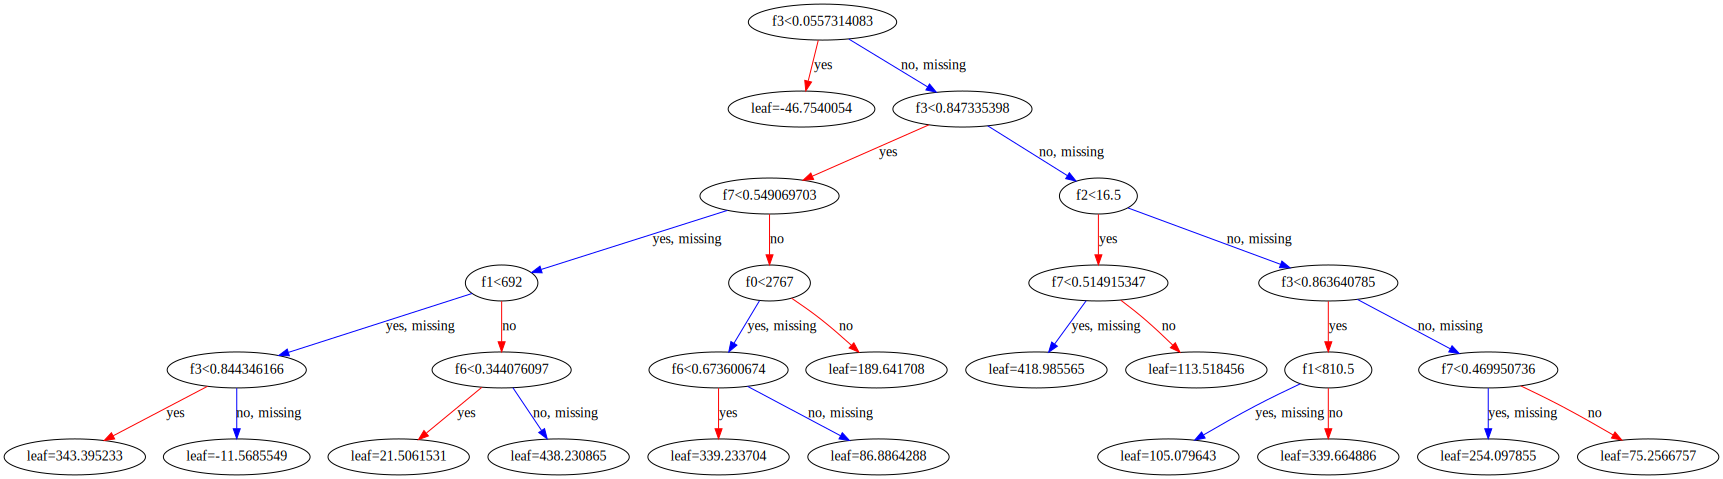

In [3]:
xgb.to_graphviz(bst_model,num_trees=20)  #可以透過 num_trees 的設定去看不同顆樹的分裂結果，以下是第 1 棵樹 ( num_trees = 0 )的結果：

<AxesSubplot:>

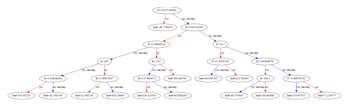

In [5]:
xgb.plot_tree(bst_model, num_trees=20)
# fig.savefig('xgb_tree.jpg')

In [15]:
cols=['M','U','PT','UP_TIME','EQP_UTIL','TC','CS','C_AI']
df_testing = df_train.drop(['TOOLG_ID','MOVE_QTY','MFG_DATE','AI'], axis=1)
df_testing[cols]= df_testing[cols].mean()
df_testing =df_testing[0:1]
# max_wip = df_testing['NO_HOLD_QTY'].max()* .75
max_wip = np.percentile(df_testing['NO_HOLD_QTY'], 50) # return 50th percentile, e.g median.
tick = (df_testing['NO_HOLD_QTY'].max() - df_testing['NO_HOLD_QTY'].min()) /400
if max_wip <=0 :
    max_wip=100
if tick <2 :
    tick = 2
print(max_wip,tick)

df = pd.DataFrame(columns = df_testing.columns)

for i in range(2000):
    df_testing['NO_HOLD_QTY']=max_wip+ tick*i
    df = df.append(df_testing,ignore_index=True)
print(df.head())        


1808.0 2
   WIP_QTY  NO_HOLD_QTY        M         U          PT   UP_TIME  EQP_UTIL  \
0   2570.0       1808.0  16.7925  0.815054  262.588917  0.977081  0.638293   
1   2570.0       1810.0  16.7925  0.815054  262.588917  0.977081  0.638293   
2   2570.0       1812.0  16.7925  0.815054  262.588917  0.977081  0.638293   
3   2570.0       1814.0  16.7925  0.815054  262.588917  0.977081  0.638293   
4   2570.0       1816.0  16.7925  0.815054  262.588917  0.977081  0.638293   

         TC        CS      C_AI  
0  0.506885  0.521573  0.298731  
1  0.506885  0.521573  0.298731  
2  0.506885  0.521573  0.298731  
3  0.506885  0.521573  0.298731  
4  0.506885  0.521573  0.298731  


In [7]:
model

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=5,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.8, tree_method='exact', validate_parameters=1,
             verbosity=None)

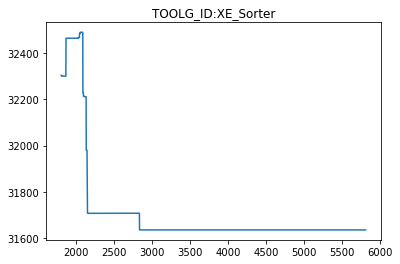

In [16]:
X_droppedtest = np.asarray(df)
# dtest = xgb.DMatrix(X_droppedtest)
# y_predict = model.predict(X_droppedtest)
y_predict = model.predict(X_droppedtest)
df['predict'] = y_predict # 預測WIP 數

plt.plot( df['NO_HOLD_QTY'] ,y_predict )
plt.title('TOOLG_ID:'+ df_train['TOOLG_ID'].iloc[0])
plt.xlabel("WIP")
plt.ylabel("MOVE")
plt.savefig('./'+df_train['TOOLG_ID'].iloc[0]+'2.pdf',width=600, height=350)#儲存檔案
plt.show()

In [9]:
y_predict

array([32304.623, 32300.928, 32300.928, ..., 31634.924, 31634.924,
       31634.924], dtype=float32)